<a href="https://colab.research.google.com/github/Maple127/public127.github.io/blob/main/chapter_linear-classification/softmax-regression-concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l
import torch

# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`



Just as high-level deep learning frameworks
made it easier to implement linear regression
(see :numref:`sec_linear_concise`),
they are similarly convenient here.


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Defining the Model

As in :numref:`sec_linear_concise`,
we construct our fully connected layer
using the built-in layer.
The built-in `__call__` method then invokes `forward`
whenever we need to apply the network to some input.


We use a `Flatten` layer to convert the fourth-order tensor `X` to second order
by keeping the dimensionality along the first axis unchanged.


In [3]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

## Softmax Revisited
:label:`subsec_softmax-implementation-revisited`

In :numref:`sec_softmax_scratch` we calculated our model's output
and applied the cross-entropy loss. While this is perfectly
reasonable mathematically, it is risky computationally, because of
numerical underflow and overflow in the exponentiation.

Recall that the softmax function computes probabilities via
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$.
If some of the $o_k$ are very large, i.e., very positive,
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types. This is called *overflow*. Likewise,
if every argument is a very large negative number, we will get *underflow*.
For instance, single precision floating point numbers approximately
cover the range of $10^{-38}$ to $10^{38}$. As such, if the largest term in $\mathbf{o}$
lies outside the interval $[-90, 90]$, the result will not be stable.
A way round this problem is to subtract $\bar{o} \stackrel{\textrm{def}}{=} \max_k o_k$ from
all entries:

$$
\hat y_j = \frac{\exp o_j}{\sum_k \exp o_k} =
\frac{\exp(o_j - \bar{o}) \exp \bar{o}}{\sum_k \exp (o_k - \bar{o}) \exp \bar{o}} =
\frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})}.
$$

By construction we know that $o_j - \bar{o} \leq 0$ for all $j$. As such, for a $q$-class
classification problem, the denominator is contained in the interval $[1, q]$. Moreover, the
numerator never exceeds $1$, thus preventing numerical overflow. Numerical underflow only
occurs when $\exp(o_j - \bar{o})$ numerically evaluates as $0$. Nonetheless, a few steps down
the road we might find ourselves in trouble when we want to compute $\log \hat{y}_j$ as $\log 0$.
In particular, in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `NaN` (Not a Number) results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining softmax and cross-entropy,
we can escape the numerical stability issues altogether. We have:

$$
\log \hat{y}_j =
\log \frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})} =
o_j - \bar{o} - \log \sum_k \exp (o_k - \bar{o}).
$$

This avoids both overflow and underflow.
We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we just
[**pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,**]
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [4]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

## Training

Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.


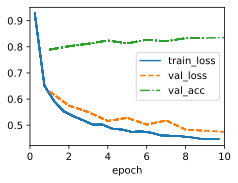

In [5]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

As before, this algorithm converges to a solution
that is reasonably accurate,
albeit this time with fewer lines of code than before.


## Summary

High-level APIs are very convenient at hiding from their user potentially dangerous aspects, such as numerical stability. Moreover, they allow users to design models concisely with very few lines of code. This is both a blessing and a curse. The obvious benefit is that it makes things highly accessible, even to engineers who never took a single class of statistics in their life (in fact, they are part of the target audience of the book). But hiding the sharp edges also comes with a price: a disincentive to add new and different components on your own, since there is little muscle memory for doing it. Moreover, it makes it more difficult to *fix* things whenever the protective padding of
a framework fails to cover all the corner cases entirely. Again, this is due to lack of familiarity.

As such, we strongly urge you to review *both* the bare bones and the elegant versions of many of the implementations that follow. While we emphasize ease of understanding, the implementations are nonetheless usually quite performant (convolutions are the big exception here). It is our intention to allow you to build on these when you invent something new that no framework can give you.


## Exercises

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.
1. INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?
1. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?
1. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?


1

In [6]:
import numpy as np

for dtype in [np.float64, np.float32, np.float16]:
    finfo = np.finfo(dtype)
    print(f"{dtype}:")
    print(f"  最小输入（避免下溢）: {np.log(finfo.tiny)}")
    print(f"  最大输入（避免上溢）: {np.log(finfo.max)}\n")

<class 'numpy.float64'>:
  最小输入（避免下溢）: -708.3964185322641
  最大输入（避免上溢）: 709.782712893384

<class 'numpy.float32'>:
  最小输入（避免下溢）: -87.3365478515625
  最大输入（避免上溢）: 88.72283935546875

<class 'numpy.float16'>:
  最小输入（避免下溢）: -9.703125
  最大输入（避免上溢）: 11.09375



2

答：
INT8 表示范围是 [-128, 127]，精度低、动态范围窄。扩展策略：

量化+缩放：用一个额外的缩放因子 scale，将原始浮点数表示为
𝑥
float
≈
𝑥
int8
×
scale
x
float
​
 ≈x
int8
​
 ×scale；

支持更广范围，但精度损失；加法/乘法需解码/反量化，非标准操作。



标准加法/乘法不直接适用：

因为操作是在量化域进行的；需要反量化或整数量化运算核（比如量化感知训练 QAT 中使用 INT8 乘加单元）。

In [7]:
x_float = torch.tensor([1.5, -2.3, 0.7])
scale = 0.1
x_int8 = torch.clamp((x_float / scale).round(), -128, 127).to(torch.int8)
x_dequant = x_int8.float() * scale

print("原始值:", x_float)
print("量化值:", x_int8)
print("反量化:", x_dequant)

原始值: tensor([ 1.5000, -2.3000,  0.7000])
量化值: tensor([ 15, -23,   7], dtype=torch.int8)
反量化: tensor([ 1.5000, -2.3000,  0.7000])


3

原因：

模型过拟合训练集；
验证集性能下降。



解决方案：

使用早停法（early stopping）；

加入权重衰减（L2 正则）；

使用dropout；

增加训练数据或数据增强。



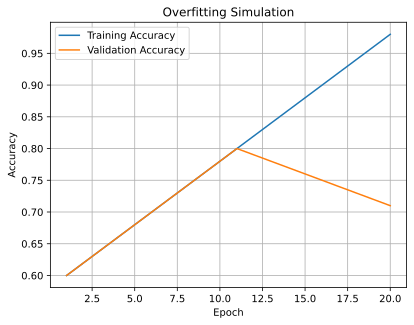

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))
train_acc = [0.6 + 0.02*i for i in range(20)]
val_acc = [0.6 + 0.02*i if i < 10 else 0.8 - 0.01*(i-10) for i in range(20)]

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Overfitting Simulation')
plt.legend()
plt.grid(True)
plt.show()

4

学习率过小：训练慢，可能停滞；

学习率合适：快速收敛；

学习率过大：震荡甚至发散。

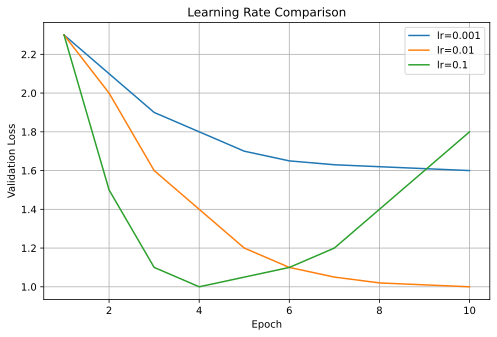

In [9]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
losses = {
    'lr=0.001': [2.3, 2.1, 1.9, 1.8, 1.7, 1.65, 1.63, 1.62, 1.61, 1.60],
    'lr=0.01':  [2.3, 2.0, 1.6, 1.4, 1.2, 1.1, 1.05, 1.02, 1.01, 1.00],
    'lr=0.1':   [2.3, 1.5, 1.1, 1.0, 1.05, 1.10, 1.20, 1.40, 1.60, 1.80]
}

plt.figure(figsize=(8, 5))
for lr, loss in losses.items():
    plt.plot(epochs, loss, label=lr)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Learning Rate Comparison')
plt.legend()
plt.grid(True)
plt.show()

[Discussions](https://discuss.d2l.ai/t/53)
